# IMA204 Practical Session - Segmentation of medical images



# Introduction

Images to use are provided in a zip file called **data.zip** to install in your local directory from where you are running this notebook.

The goal of this practical session is to push K-means segmentation method as a pre-segmentation tool on different types of medical images: CT scans for the segmentation of kidneys and tumors, MRI for the corpus callosum in the brain , temporal sequences of MRI images for segmentation of the myocardium.

You are provided with pre-processing ideas. 
You will have to adjust a pipeline for **AT LEAST** one application (kidney/tumor, corpus callosum or heart).

You have to submit your code and comment your results. 

**Deadline**: You will have to upload a single jupyter notebook .ipynb with your answers (code + text) before the deadline (please check on Ecampus/Moodle). 

**The uploaded file should be named 'TP_SegMedImage_YOURSURNAME.ipynb'.** 

**RUN THE WHOLE NOTEBOOK PRIOR TO CHANGING THE SELECTION OF TEST IMAGES PER USE CASE AS PROVIDED HYPER-PARAMETER VALUES CAN BE QUITE SENSITITVE TO EXAMPLE IMAGE YOU ARE USING.**

In [468]:
import os
import numpy as np
import matplotlib.pyplot as plt

# For ploting utilities of contours on images
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For listing files in local foler
import glob

# For loading .mat files
from scipy.io import loadmat

import skimage
from skimage.io import imread
from skimage import morphology
from skimage.segmentation import watershed 
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from scipy import ndimage
from skimage.measure import find_contours
from skimage.morphology import convex_hull_image
import skimage.morphology as morpho  
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage.filters import gaussian


# For Kmeans
import cv2 


Working_directory = os.getcwd()
print('Working_directory = ',Working_directory)


Working_directory =  c:\Users\Louis\Documents\Telecom\Cours\2A\IMA204\TP5 Medical Imaging


In [469]:
def my_kmeans(image,k):
    #k = number of clusters
    
    # Reshaping the image  
    pixel_vals = image.reshape((-1,1)) 

    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria   = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) #criteria
    retval, labels, centers = cv2.kmeans(pixel_vals, k, 
                None, criteria, 10, cv2.KMEANS_PP_CENTERS) 
    centers = np.uint8(centers) # convert data into 8-bit values 
    
    segmented_data   = centers[labels.flatten()] # Mapping labels to center points( RGB Value)
    segmented_image  = segmented_data.reshape((image.shape)) # reshape data into the original image dimensions

    segmented_labels = labels # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape((image.shape)) # reshape data into the original image dimensions
    
    return segmented_image,segmented_labels

## Abdominal CT 

You have at your disposal **6 abdominal CT scans** of different subjects. Subjects may have renal tumor. You also have the manual segmentations for both kidney and, when present, the tumor. 

Variables defined: <br>
* abdominalCT_path
* listImagesabdCT
* Img_abdo_ex
* Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

There are 6 abdomical CT images
Reading image  c:\Users\Louis\Documents\Telecom\Cours\2A\IMA204\TP5 Medical Imaging/data/abdominalCT\CTs1.tiff
[  0 127 255]


Text(0.5, 1.0, 'Image +contour tumor')

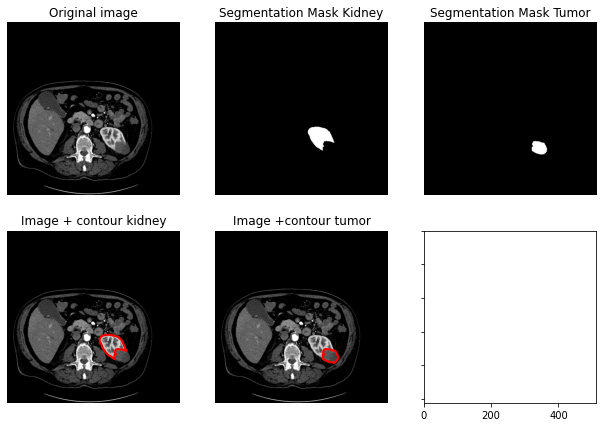

In [470]:
abdominalCT_path = Working_directory + '/data/abdominalCT'  
os.listdir(abdominalCT_path)
listImagesabdCT=glob.glob(abdominalCT_path + '/*-seg.tiff')
print('There are', len(listImagesabdCT),  'abdomical CT images')

# Choose a figure and plot it with the ground truth segmentation
indexIm=0 # between 0 and 5

# Abdominal CT
filename_Segmentation = listImagesabdCT[indexIm]
Labels_abdo_ex   = imread(filename_Segmentation)
filename         = filename_Segmentation[:-9] + '.tiff'
Img_abdo_ex      = imread(filename) 

print('Reading image ', filename)
print(np.unique(Labels_abdo_ex))

if Img_abdo_ex.shape != Labels_abdo_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Labels_abdo_ex we may have two values: 127 is for kidney and 255 for renal tumor
Seg_abdo_kidney_ex=Labels_abdo_ex==127
if np.sum(Seg_abdo_kidney_ex)==0:
  print('There is no kidney')
Cont_abdo_kidney_ex = find_contours(Seg_abdo_kidney_ex, 0.5)

Seg_abdo_tumor_ex=Labels_abdo_ex==255
if np.sum(Seg_abdo_tumor_ex)==0:
  print('There is no tumor')
Cont_abdo_tumor_ex = find_contours(Seg_abdo_tumor_ex, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_abdo_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(Seg_abdo_kidney_ex,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask Kidney")
grid[2].imshow(Seg_abdo_tumor_ex,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Segmentation Mask Tumor")
grid[3].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_kidney_ex:
  grid[3].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[3].axis('off')
grid[3].set_title("Image + contour kidney")
grid[4].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_tumor_ex:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[4].axis('off')
grid[4].set_title("Image +contour tumor")


# Brain MRI

Here you can select medial slices of the brain of **4 different subjects**. You also have manual segmentations of the corpus callosum.

Variables defined: <br>
* brainMRI_path
* listImagesbrainMRI
* Seg_brain_ex
* Img_brain_ex

There are 4 brain MRI images
['c:\\Users\\Louis\\Documents\\Telecom\\Cours\\2A\\IMA204\\TP5 Medical Imaging/data/brainMRI\\MRIs1-seg.png', 'c:\\Users\\Louis\\Documents\\Telecom\\Cours\\2A\\IMA204\\TP5 Medical Imaging/data/brainMRI\\MRIs2-seg.png', 'c:\\Users\\Louis\\Documents\\Telecom\\Cours\\2A\\IMA204\\TP5 Medical Imaging/data/brainMRI\\MRIs3-seg.png', 'c:\\Users\\Louis\\Documents\\Telecom\\Cours\\2A\\IMA204\\TP5 Medical Imaging/data/brainMRI\\MRIs4-seg.png']
Reading image  c:\Users\Louis\Documents\Telecom\Cours\2A\IMA204\TP5 Medical Imaging/data/brainMRI\MRIs4.png


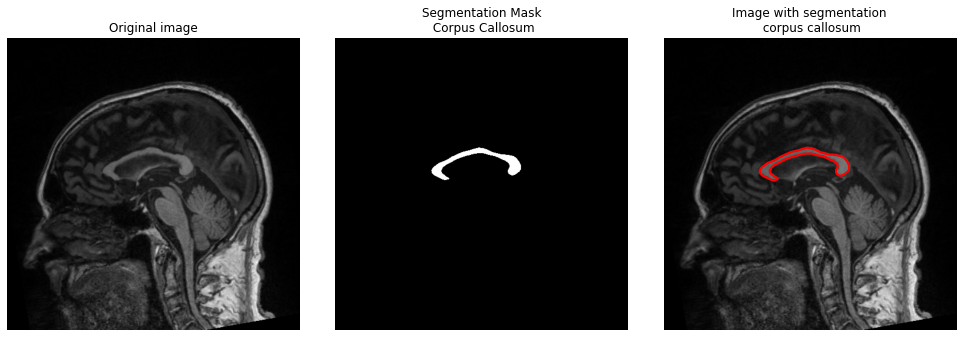

In [471]:
brainMRI_path = Working_directory + '/data/brainMRI'
os.listdir(brainMRI_path)
listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')
print(listImagesbrainMRI)

# Choose a brain MRI and plot it with the ground truth segmentation
indexIm      = 3 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename) 

print('Reading image ', filename)

if Img_brain_ex.shape != Seg_brain_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Im Seg we have masks of the corpus callosum
maskCC      = Seg_brain_ex==255
contourMask = find_contours(maskCC, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_brain_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskCC,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask\n Corpus Callosum");
grid[2].imshow(Img_brain_ex, cmap='gray')
for contour in contourMask:
  grid[2].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[2].axis('off')
grid[2].set_title("Image with segmentation\n corpus callosum")
plt.show()

# Cardiac MRI 

The last section is about MRI sequences of the heart. 
You are provided with **a single use case**. 
Your goal is to segment the left ventricule. Be careful, the segmentation is not a maks but a series of points (landmarks). To obtain a binary mask, you should first interpolate the points (using for instance a spline). <br> 

The structure of this image data is more complex and needs some coding to load single slices to segment.


Variables defined: <br>
* MRIheart_path
* Img_cardiac_ex
* Seg_cardiac_ex


MRI volume of the heart composed of 11 slices along the z axis and 20 temporal frames. Each slice is an image  256  x  256
For each slice and at each time frame we have a manual segmentation composed of 65 2D landmarks
Be careful, some slices do not have the left ventricle and the manual segmentation is not simply empty but it contains the value: [[-99999]]


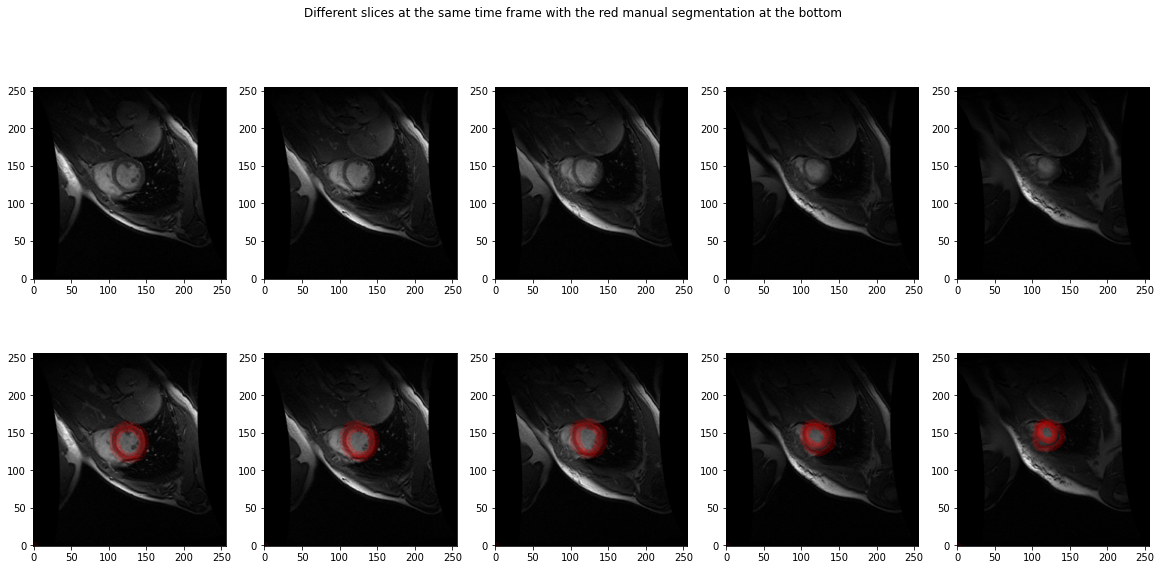

In [472]:

# Read one case
MRIheart_path = Working_directory + '/data/MRIheart/'
os.listdir(MRIheart_path)
data          = loadmat(MRIheart_path + 'dataMRIheart.mat')
data          = data['data']
seg           = loadmat(MRIheart_path + 'segMRIheart.mat')
seg           = seg['seg']

Ex_index_select = 8
Img_cardiac_ex = data[:,:,Ex_index_select,1] # can be index 4,5,6,...
Cont_cardiac_ex = seg[Ex_index_select,1][:]

print('MRI volume of the heart composed of', data.shape[2], 'slices along the z axis and', data.shape[3], 
'temporal frames. Each slice is an image ', data.shape[0], ' x ',  data.shape[1])
print('For each slice and at each time frame we have a manual segmentation composed of',seg[4,4].shape[0] , '2D landmarks')

print('Be careful, some slices do not have the left ventricle and the manual segmentation is not simply empty but it contains the value:', seg[0,0] )

plt.figure(figsize=(20, 9))
plt.suptitle('Different slices at the same time frame with the red manual segmentation at the bottom')
plt.subplot(2, 5, 1)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 2)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 3)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 4)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 5)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 6)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[4,1][:,0], seg[4,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 7)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[5,1][:,0], seg[5,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 8)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[6,1][:,0], seg[6,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 9)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[7,1][:,0], seg[7,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 10)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[8,1][:,0], seg[8,1][:,1], c='r',alpha=0.1) 

## For cardiac MRI: how to create a binary mask from the provided contours

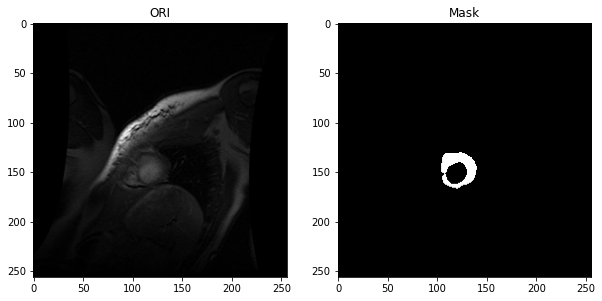

In [473]:
from skimage.draw import polygon

# Remove [0 0] point in provided contour
Cont_cardiac_ex = Cont_cardiac_ex[~np.all(Cont_cardiac_ex == 0, axis=1)]

Seg_cardiac_ex   = np.zeros_like(Img_cardiac_ex, dtype='bool')
rr, cc = polygon(Cont_cardiac_ex[:, 1], Cont_cardiac_ex[:, 0], Img_cardiac_ex.shape)
Seg_cardiac_ex[rr, cc] = 1

fig, axes        = plt.subplots(1,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_cardiac_ex,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Seg_cardiac_ex,cmap='gray')
ax[1].set_title("Mask")

plt.show()

# Preliminaries
## Mathematical Morphology

Incitations to use morphological operators seen during the previous lectures to segment the provided images. 


Think about the structural elements and the hyper-parameters ... We typically adapt their values to the image resolution and type of structures targeted in our segmentation (eg. brigth or dark).



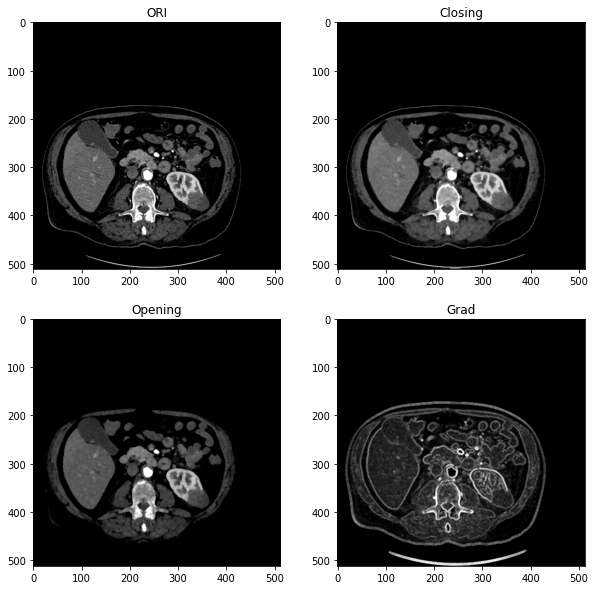

In [474]:
#Select input image
# Img_test         = Img_cardiac_ex
# Img_test         = Img_brain_ex
Img_test         = Img_abdo_ex ; # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

# Define Element
Radius           = 2
se               = disk(Radius)

# Morpho closing
Img_test_close  = morpho.closing(Img_test,se)

# Morpho Opening
Img_test_open    = morpho.opening(Img_test,se)

# Morpho Gradient
Img_test_grad  = morpho.dilation(Img_test,se)-morpho.erosion(Img_test,se)


#Figure display
fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Img_test_close,cmap='gray')
ax[1].set_title("Closing")
ax[2].imshow(Img_test_open,cmap='gray')
ax[2].set_title("Opening")
ax[3].imshow(Img_test_grad,cmap='gray')
ax[3].set_title("Grad")

plt.show()

# Preliminaries
## Regular filtering

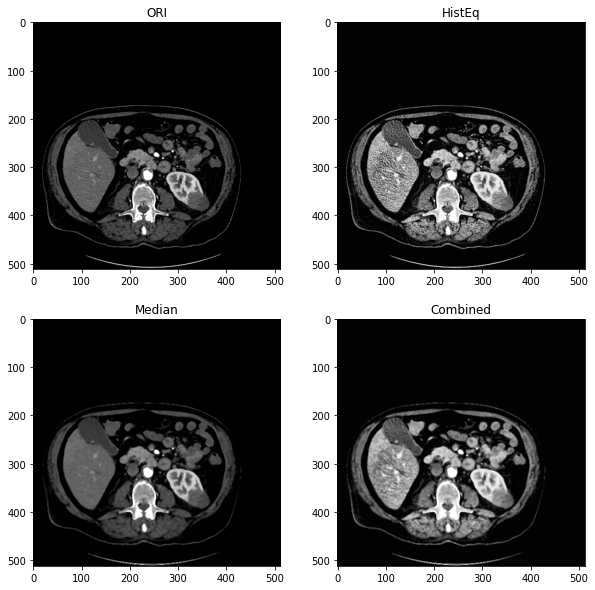

In [475]:

img_histeq    = skimage.exposure.equalize_adapthist(Img_test, clip_limit=0.03)
img_median    = ndimage.median_filter(Img_test, size=4)
img_histeqmed = ndimage.median_filter(img_histeq, size=4)

fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(img_histeq,cmap='gray')
ax[1].set_title("HistEq")
ax[2].imshow(img_median,cmap='gray')
ax[2].set_title("Median")
ax[3].imshow(img_histeqmed,cmap='gray')
ax[3].set_title("Combined");




# ASSIGNMENT:

**Question** 
Develop a segmentation pipeline building upon **kmeans** as proposed below for **at least one application** and report quality of segmentation results comparing your results to the provided ground truth on multiple images.

We want you to focus on **pre-processing** your image AND **post process** your segmentation result to extract **THE structure of interest**. For the postprocessing you can rely on extraction of connected components and apply to criteria (size, shape, position,..) to extract the composant that most likely corresponds to the structure of interest. 


When processing medical images, and given that you are provided with several ground-truth (gt) segmentations you can push the exercice to consider: <br>
* Cropping the field of view to remove the background (a common issue in medical images)
* Target a range of intensity values based on learning from the gt masks and corresponding images 
* Learn priors on shape/intensity statistics from the provided gt masks


## Kmeans routine to segment your images
Kmeans is very often used as pre-segmentation to initialise a finer segmentation.

Provides a segmentation of the image using k-means clustering.
Be careful: Kmeans uses random initialisation and is therefore different at each run and randomly assigns  labels to clusters (0,1,2,...,K).

 



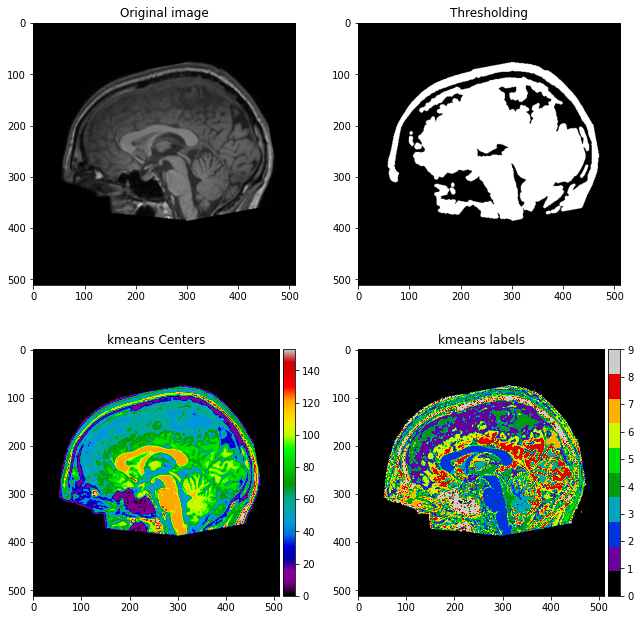

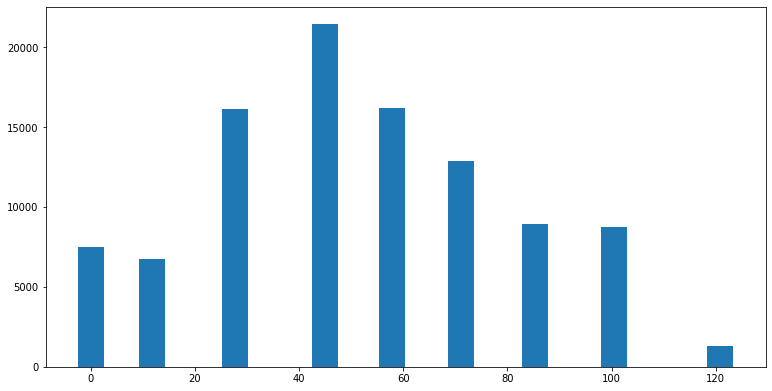

Yout Target_value =  80
Distance of your Target_value to Centers =  [79 22 41 21 35 74  8 52  6 68]
Your selected label (starting with 0)=  8


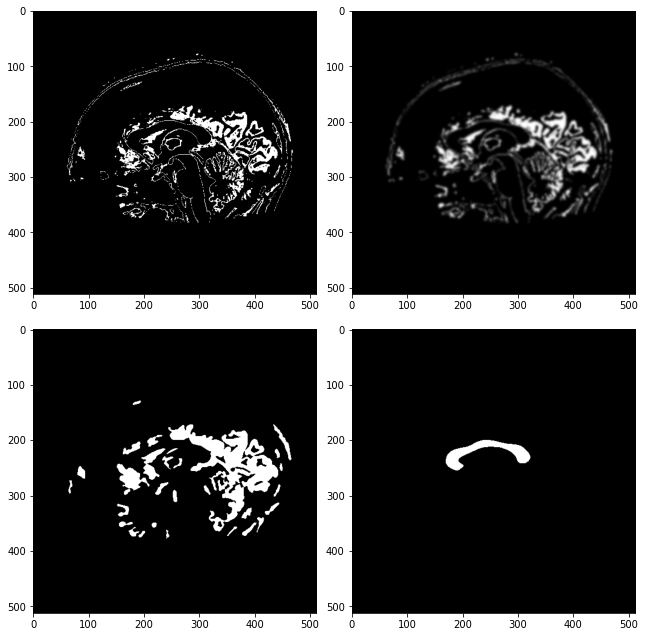

In [476]:
indexIm_test      = 0 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm_test]
Seg_brain_test = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_test = imread(filename)


# Image use-case and HYPER-PARAMETER values provided as a good start

# Img_test         = Img_abdo_ex ; Img_seg_gt       = Seg_abdo_kidney_ex # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex
# nber_clusters    = 10; Target_value_thresh = 180 # For cardiac image
# Img_test            = Img_cardiac_ex; Img_seg_gt       = Seg_cardiac_ex
# nber_clusters       = 10; Target_value_thresh = 150 # For abdo image
# Img_test          = Img_brain_ex ; Img_seg_gt       = Seg_brain_ex
# nber_clusters     = 10; Target_value_thresh = 50 # For brain image
Img_test          = Img_brain_test ; Img_seg_gt       = Seg_brain_test
nber_clusters     = 10; Target_value_thresh = 50 # For brain image




# [1] Example of segmentation via simple threshold 
# Compute a mask thresholding above target value
Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh, 
                            min_size=500,connectivity=1),
                             area_threshold=500)
Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
Seg_thresh = Seg_thresh.astype('uint8')


# [2] Example of segmentation via kmeans 
Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Display results
fig, axes = plt.subplots(2,2, figsize=(9,9))
ax        = axes.ravel()

ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(Seg_thresh, cmap='gray')
ax[1].set_title('Thresholding')

tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')

tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')

fig.tight_layout()
plt.show();

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(Img_test, Img_label_mask)
    Img_label_means[i] = tmp[0]
#print(Img_label_means)

# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(), 
                                         bins=Bins)
bar_width = 5
fig       = plt.figure(figsize=(10, 5))
ax        = fig.add_axes([0,0,1,1])
ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
plt.show()

# Set a target intensity value and get the Kmeans label closest to it
Target_value = cv2.mean(Img_test, Seg_thresh)
Target_value = Target_value[0]
Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)
print('Yout Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)



# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2, 
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(9,9))
ax        = axes.ravel()
ax[0].imshow(Img_label_select, cmap='gray')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[3].imshow(Img_seg_gt, cmap='gray')

fig.tight_layout()
plt.show()






---


## Extract the structure of interest from your segmentation mask

* CODE TO WRITE ON TWO EXAMPLES FROM SAME USE-CASE <br>
* RETURN A QUALITY METRIC ON THE SEGMENTATION PROVIDED BY YOU COMPARED TO THE PROVIDED GROUND TRUTH


#### Process

The idea is to extract some features of the desired component from a reference preprocessed image.<br>
The features extracted are :
- area
- perimeter
- centroid coordinates
- convexity defined as : $$\frac{\mathcal{P}_\text{convex hull}}{\mathcal{P}_{component}} \hspace{15pt}(\leq 1)$$


**We assume that the reference and test images have the same width and height. Hence we only compute the absolute coordinates of centroids and not the relative position in the image**


In [477]:
from collections import deque


def components_to_images(im, comp):
    """
        Converts a list of components generated by extract_components into images
    """
    # plt.imshow(comp[1], cmap='gray')
    res_img = [np.zeros(im.shape) for i in range(len(comp))]

    for i in range(len(comp)):
        for j in range(len(comp[i])):
            x, y = comp[i][j]

            res_img[i][x][y] = 1

    return res_img



def extract_components(binary_image):
    n_rows, n_cols = binary_image.shape
    visited = np.zeros_like(binary_image, dtype=bool)
    components = []

    for row in range(n_rows):
        for col in range(n_cols):
            if binary_image[row, col] == 1 and not visited[row, col]:
                component = []
                queue = deque([(row, col)])
                visited[row, col] = True
                while queue:
                    r, c = queue.popleft()
                    component.append((r, c))
                    for dr, dc in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                        r_, c_ = r+dr, c+dc
                        if (0 <= r_ < n_rows) and (0 <= c_ < n_cols) and binary_image[r_, c_] == 1 and not visited[r_, c_]:
                            queue.append((r_, c_))
                            visited[r_, c_] = True
                components.append(component)
    return components


# Get area of a component
def get_component_area(binary_image):
    return np.count_nonzero(binary_image)


# Get contour length of components
def get_component_perimeter(binary_image):
    contour = find_contours(binary_image.clip(max=1))[0]
    return len(contour)

# Get the centroid of the component
def get_component_centroid(binary_image):
    coords = np.argwhere(binary_image.clip(max=1) == 1) # Image can be from 0 255
    x_mean, y_mean = np.mean(coords, axis=0).astype(int)
    res = []
    return x_mean, y_mean

# Convexity is defined as the ratio : P(convex_hull)/P(comp)
def get_component_convexity(binary_image):
    comp_perimeter = get_component_perimeter(binary_image)
    comp_convex_hull = convex_hull_image(binary_image)
    convex_hull_perimeter  = get_component_perimeter(comp_convex_hull)
    return convex_hull_perimeter / comp_perimeter

def get_components_contours():
    pass

#### Choice of reference image

We choose the corpus callosum of MRI4 (index 3) as reference to identify it in other MRIs.<br>
Thus we extract the features mentioned above.

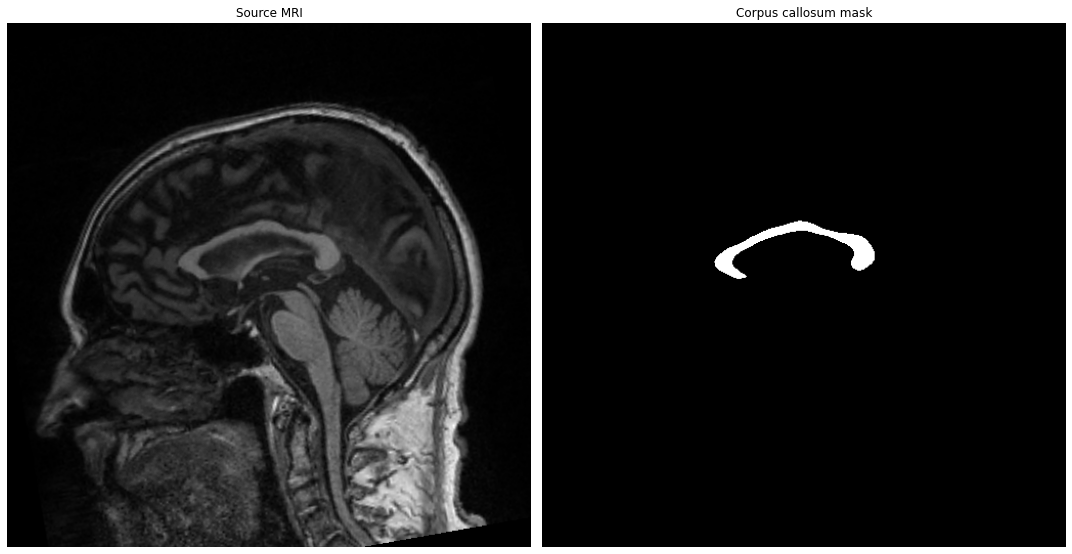

In [478]:
indexIm_ref      = 3 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm_ref]
Seg_brain_ref = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ref = imread(filename)

fig, ax = plt.subplots(1, 2, figsize=(15, 9))
ax[0].imshow(Img_brain_ref, cmap='gray')
ax[0].set_title('Source MRI')
ax[0].axis('off')
ax[1].imshow(Seg_brain_ref, cmap='gray')
ax[1].set_title('Corpus callosum mask')
ax[1].axis('off')

fig.tight_layout()
plt.show()

In [479]:
ref_centroid = get_component_centroid(Seg_brain_ref)
ref_perimeter = get_component_perimeter(Seg_brain_ref)
ref_area = get_component_area(Seg_brain_ref)
ref_convexity = get_component_convexity(Seg_brain_ref)

print(f'Centroid coordinates : {ref_centroid}')
print(f'Perimeter : {ref_perimeter}')
print(f'Area : {ref_area}')
print(f'Convexity : {ref_convexity}')

Centroid coordinates : (217, 250)
Perimeter : 541
Area : 2078
Convexity : 0.7929759704251387


#### Processing a new image

Now we will use these these descriptors on another brain MRI

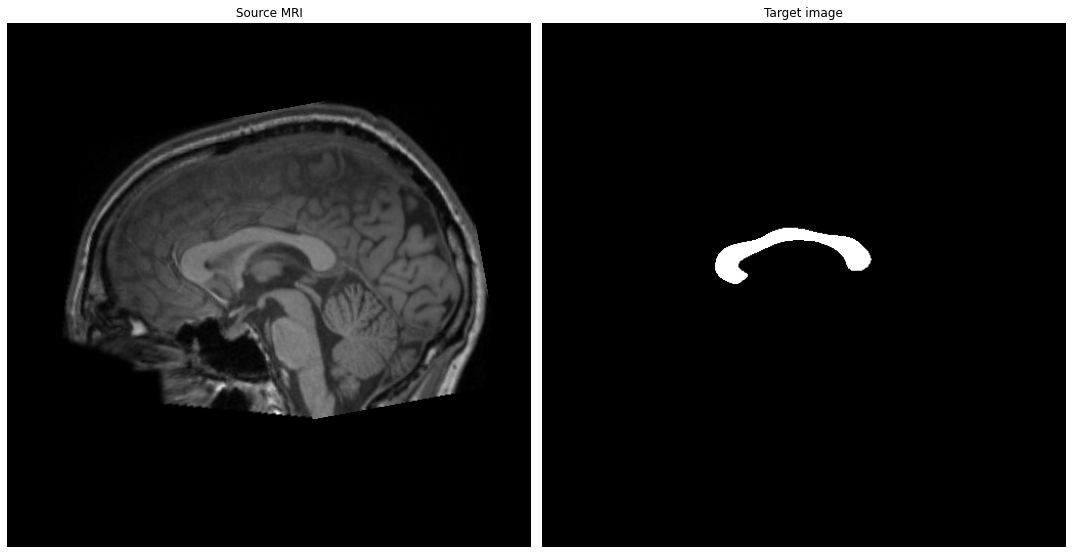

In [480]:
indexIm_ref      = 0 # Image on which we test the method
filename_seg = listImagesbrainMRI[indexIm_ref]
Seg_brain_test = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_test = imread(filename)


fig, ax = plt.subplots(1, 2, figsize=(15, 9))
ax[0].set_title('Source MRI')
ax[0].imshow(Img_brain_test, cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[1].set_title('Target image')
ax[1].imshow(Seg_brain_test, cmap='gray')

fig.tight_layout()
plt.show()

#### Preprocessing pipeline

We first need to preprocess the source MRI. To achieve that, we use the same preprocessing process as the example above.

However, it seems that comparing 

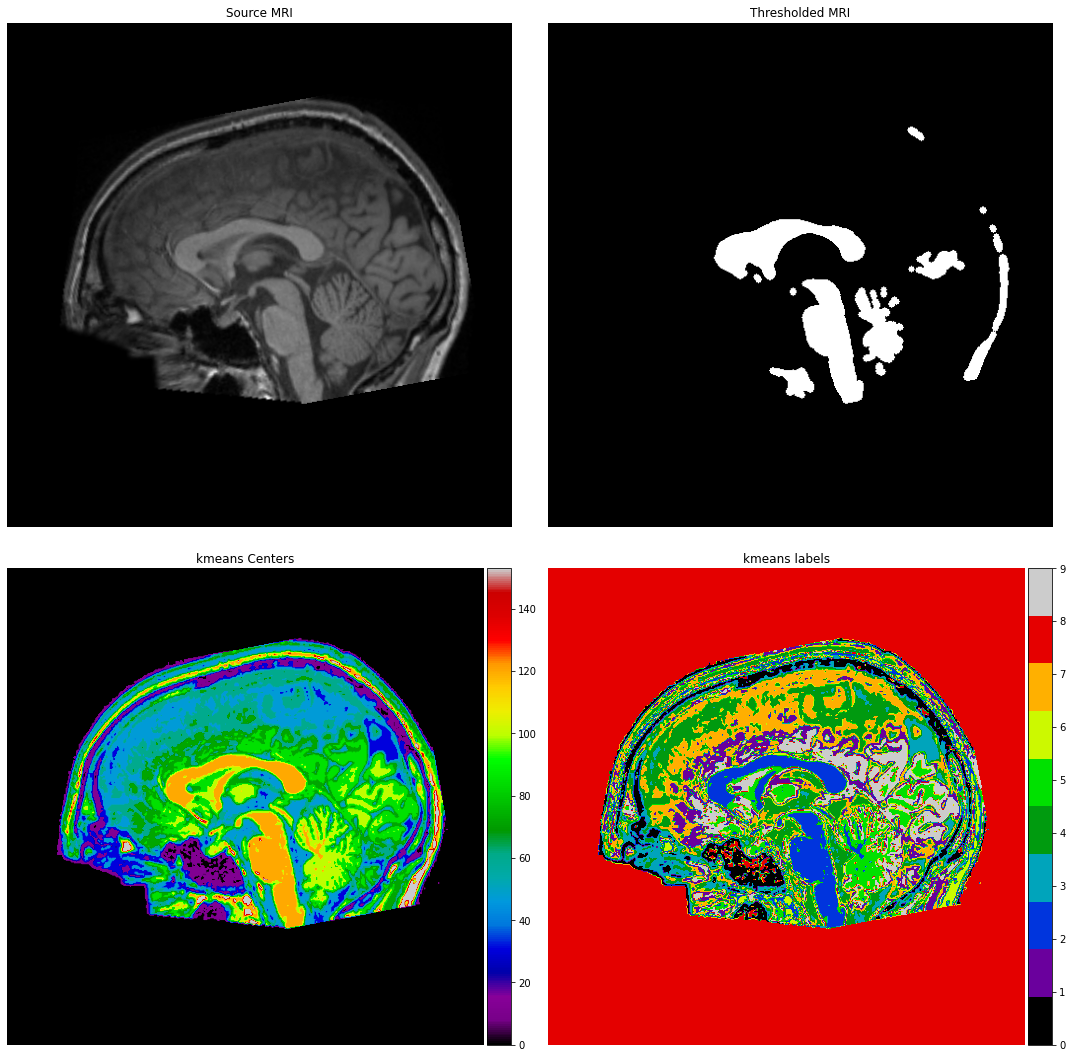

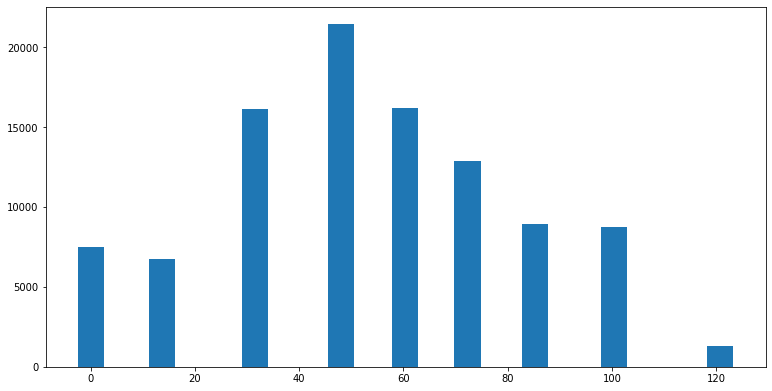

Yout Target_value =  114
Distance of your Target_value to Centers =  [100  41   7  82  66  13  40  53 113  28]
Your selected label (starting with 0)=  2


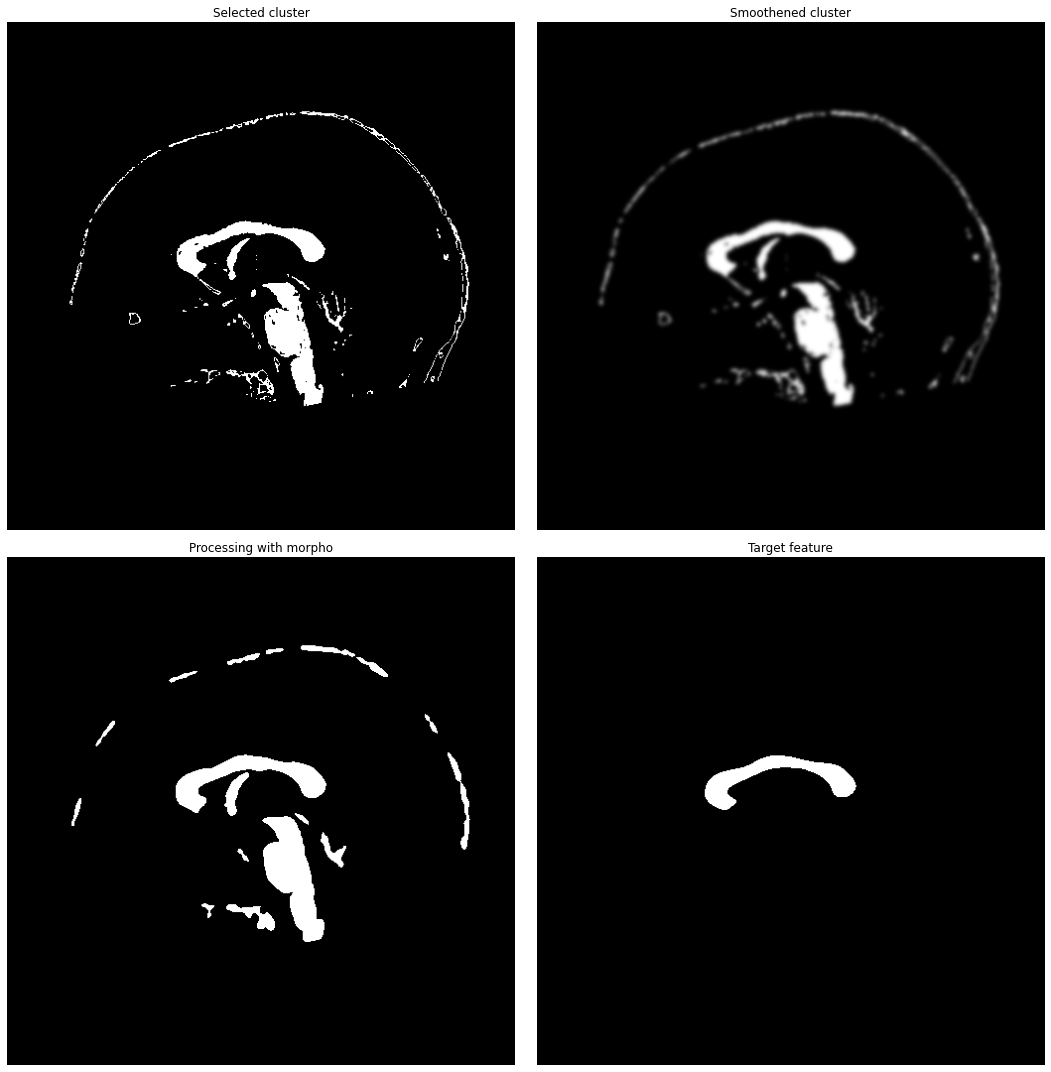

In [481]:
# APPLYING KMEANS
nber_clusters = 10
Target_value_thresh = 90

# Thresholded image
Seg_thresh_test = morphology.remove_small_holes(morphology.remove_small_objects(
    Img_brain_test > Target_value_thresh, min_size=500, connectivity=1), area_threshold=500)
Seg_thresh_test = morphology.opening(Seg_thresh_test, morphology.disk(3))
Seg_thresh_test = Seg_thresh_test.astype('uint8')

# kmeans
Seg_km_test,Seg_km_labels_test = my_kmeans(Img_brain_test,nber_clusters)
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
ax = axes.ravel()

for a in ax:
    a.axis('off')

ax[0].imshow(Img_brain_test, cmap='gray')
ax[0].set_title('Source MRI')
ax[1].imshow(Seg_thresh_test, cmap='gray')
ax[1].set_title('Thresholded MRI')

tmp       = ax[2].imshow(Seg_km_test, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')

tmp     = ax[3].imshow(Seg_km_labels_test, cmap=Colormap)
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')

fig.tight_layout()
plt.show()

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels_test==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(Img_brain_test, Img_label_mask)
    Img_label_means[i] = tmp[0]

# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(), 
                                         bins=Bins)

bar_width = 5
fig       = plt.figure(figsize=(10, 5))
ax        = fig.add_axes([0,0,1,1])
ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
plt.show()

# Set a target intensity value and get the Kmeans label closest to it
Target_value = cv2.mean(Img_brain_test, Seg_thresh_test)
Target_value = Target_value[0]
Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)
print('Yout Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)


# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels_test==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2, 
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(15,15))
ax        = axes.ravel()
ax[0].set_title('Selected cluster')
ax[0].imshow(Img_label_select, cmap='gray')
ax[0].axis('off')
ax[1].set_title('Smoothened cluster')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[1].axis('off')
ax[2].set_title('Processing with morpho')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[2].axis('off')
ax[3].set_title('Target feature')
ax[3].imshow(Seg_brain_test, cmap='gray')
ax[3].axis('off')

fig.tight_layout()
plt.show()

We have selected the right cluster and preprocessed it.

In the flollowing steps we will:
- extract each element from the cluster
- compute all the feature selectors for each of them
- keep the best match

For the last step, we will first compare the coordinates of each extracted element to the coordinates of the reference element.

Then for each remaining element, we compute a score as a linear combination of the other selector.<br>
Each value is weighted by a coefficient which correpond to the importance of the selector.

Intuitively we choose the following ranking between selectors : 
1. area
2. perimeter
3. convexity

However, the way these features are combined together is a bit arbritrary.<br>
In my case, I chose to compute their sum. Indeed, their range almost respects the hierarchy above.

In [482]:
im = Img_label_select_smooth_clean.astype(int)


def extract_selectors(im):
    """
        This function computes the selectors mentioned above for a binary image.
        It first isolate each shape in a separate image
        Then, selectors are computed for each of them
    """

    comps = extract_components(im)
    comp_images = components_to_images(im, comps)

    # We compute the selectors of each feature
    features = []
    for i in range(len(comp_images)):
        temp_img = comp_images[i]
        centroid = get_component_centroid(temp_img)
        perimeter = get_component_perimeter(temp_img)
        area = get_component_area(temp_img)
        convexity = get_component_convexity(temp_img)
        features.append((centroid, perimeter, area, convexity))

    return features, comp_images



def select_feature(ref_selectors, test_features):
    """
        This function returns the index of the most probable feature
        according to a reference 
    """

    ref_centroid, ref_perimeter, ref_area, ref_convexity = ref_selectors[0]
    x_ref, y_ref = ref_centroid
    ref_score = ref_perimeter + ref_area + ref_convexity

    features_params = []

    # Centroids processing
    for (centroid, perimeter, area, convexity) in test_features:
        # index, (centroid, perimeter, area, convexity)
        x1, y1 = centroid
        distance2 = (x1-x_ref)**2 + (y1-y_ref)**2
        score = perimeter + area + convexity
        score_diff = abs(ref_score - score)

        features_params.append([distance2, score_diff])
    
    features_params = np.array(features_params)
    
    # First discriminate by distances
    # We only keep half of the features (assuming that their are more than one)
    selected_by_distance = np.argpartition(features_params[:,0], len(features_params) // 2)[:len(features_params) // 2]

    # Then discriminate by score
    selected = np.argmin(features_params[:,1][selected_by_distance])

    print(f'Selected feature index : {selected}')
    return selected_by_distance[selected]



#### Test of the process and plot of results

Selected feature index : 4


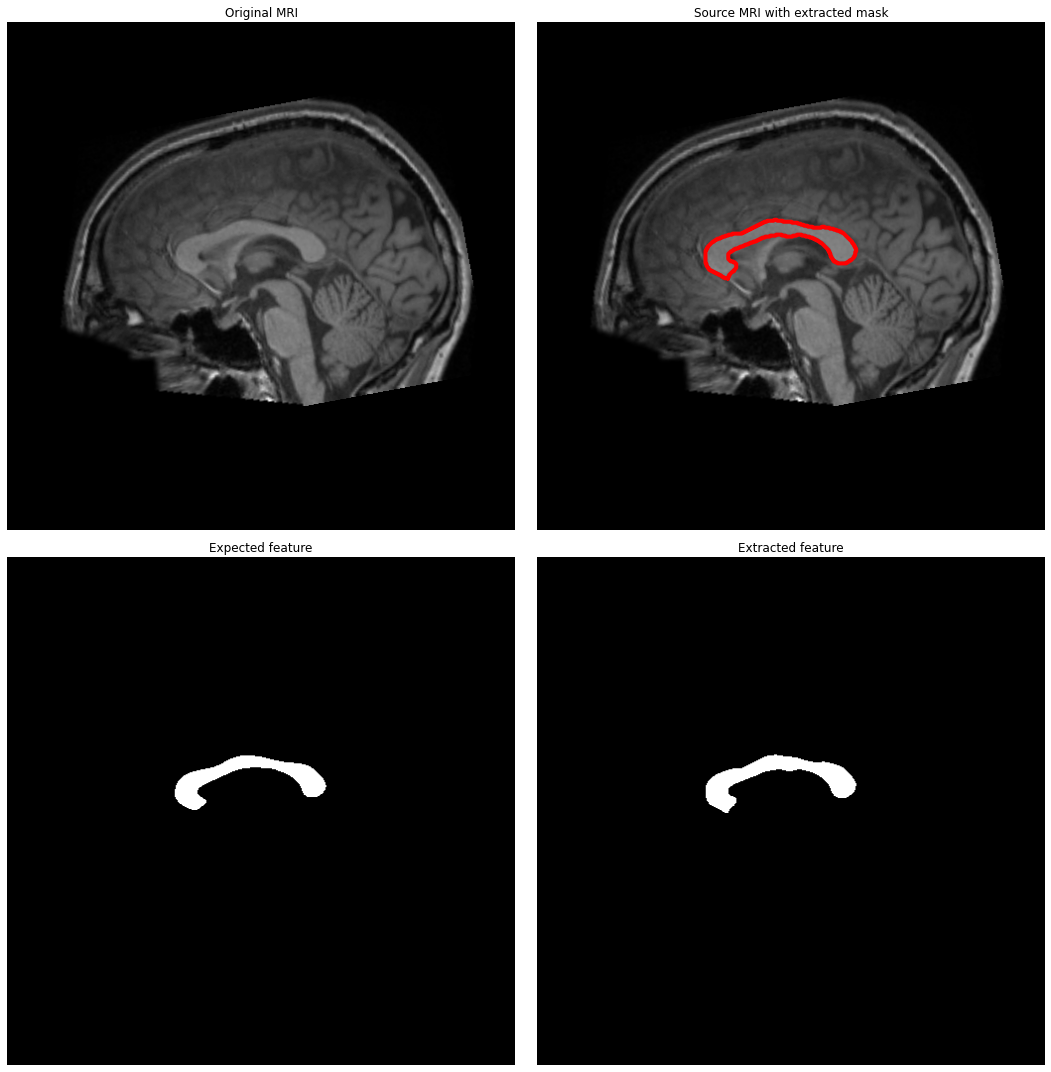

In [483]:


# =========================== TESTING ==================================
ref_feature, ref_images = extract_selectors(Seg_brain_ref.clip(max=1))
test_features, test_images = extract_selectors(im)

selected_index = select_feature(ref_feature, test_features)
selected_image = test_images[selected_index]

test_mask = find_contours(selected_image)


fig, axes = plt.subplots(2, 2, figsize=(15, 15))
ax = axes.ravel()
ax[0].set_title('Original MRI')
ax[0].imshow(Img_brain_test, cmap='gray')
ax[0].axis('off')
ax[1].set_title('Source MRI with extracted mask')
ax[1].imshow(Img_brain_test, cmap='gray')
for contour in test_mask:
    ax[1].plot(contour[:,1], contour[:,0], linewidth=4, c='r')
ax[1].axis('off')
ax[2].set_title('Expected feature')
ax[2].imshow(Seg_brain_test, cmap='gray')
ax[2].axis('off')
ax[3].set_title('Extracted feature')
ax[3].imshow(selected_image, cmap='gray')
ax[3].axis('off')
plt.tight_layout()
plt.show()

#### Conclusion

We see that the process has worked. However, the extracted feature is a bit deformed. This is probably due to the kmeans process. The corpus callosum has not been perfectly segmented. As a solution, we could increase the number of clusters and hope that imperfections are set in another cluster than the corpus callosum.<br>
Once the source MRI is properly preprocessed, the rest of the process seems to be robust.

#### Drawbacks

The major problem of this implementation is the pre-processing step. I used the method suggested (using a threslhold and kmeans) is highly sensitive to MRI quality.<br>
Parameters completely change from one image to another, especially the threshold.